# Model bias analysis

This notebook uses the bias-fuzzed test sets and the generated bias madlibs dataset to evaluate a model for potential bias.

In [79]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline

from model_tool import ToxModel, compute_auc
import model_bias_analysis

# autoreload makes it easier to interactively work on code in the model_bias_analysis module.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
%%time

MODEL_DIR = '../models/'

# Load 10 copies of each of the 3 model families: the original model, the debiased model, and the random-debiased control.

wiki_model_names = ['wiki_cnn_v3_{}'.format(i) for i in xrange(100, 110)]
wiki_models = [ToxModel(name) for name in wiki_model_names]

random_model_names = ['wiki_debias_random_cnn_v3_{}'.format(i) for i in xrange(100, 110)]
random_models = [ToxModel(name) for name in random_model_names]

debias_model_names = ['wiki_debias_cnn_v3_{}'.format(i) for i in xrange(100, 110)]
debias_models = [ToxModel(name) for name in debias_model_names]

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
max_sequence_length: 250
stop_early: True
embedding_trainable: False

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
max_sequence_length: 250
stop_early: True
embedding_trainable: False

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
max_sequence_length: 250
stop_early

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
max_sequence_length: 250
stop_early: True
embedding_trainable: False

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
max_sequence_length: 250
stop_early: True
embedding_trainable: False

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
max_sequence_length: 250
stop_early

In [14]:
all_model_families = [wiki_models, random_models, debias_models]
all_model_families_names = [wiki_model_names, random_model_names, debias_model_names]

## Load datasets

In [15]:
all_models = wiki_models + random_models + debias_models

In [16]:
%%time

madlibs = model_bias_analysis.load_maybe_score(
    all_models,
    orig_path='../eval_datasets/bias_madlibs_89k.csv',
    scored_path='../eval_datasets/bias_madlibs_89k_scored.csv',
    postprocess_fn=model_bias_analysis.postprocess_madlibs)

Using previously scored data: ../eval_datasets/bias_madlibs_89k_scored.csv
CPU times: user 560 ms, sys: 188 ms, total: 748 ms
Wall time: 889 ms


In [17]:
%%time

wiki_test = model_bias_analysis.load_maybe_score(
    all_models,
    orig_path='../data/wiki_test.csv',
    scored_path='../data/wiki_test_scored.csv',
    postprocess_fn=model_bias_analysis.postprocess_wiki_dataset)

Using previously scored data: ../data/wiki_test_scored.csv
CPU times: user 336 ms, sys: 352 ms, total: 688 ms
Wall time: 758 ms


## AUC

Overall AUC on the madlibs dataset improved from 0.956 to 0.973 for the debiased model.

original models:
mean AUC: 0.955535393587
median: 0.958757864055
stddev: 0.0130814338517


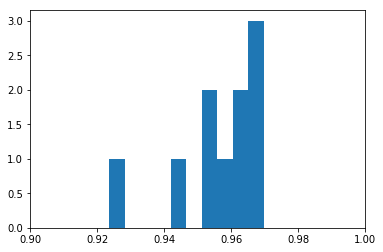



random models:
mean AUC: 0.950003588884
median: 0.954756525432
stddev: 0.0184835831212


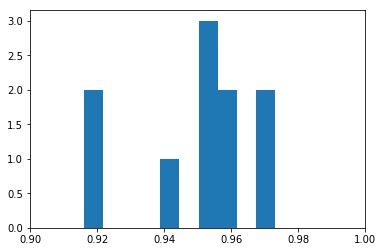



debias models:
mean AUC: 0.972874954137
median: 0.974201714707
stddev: 0.00714326118155


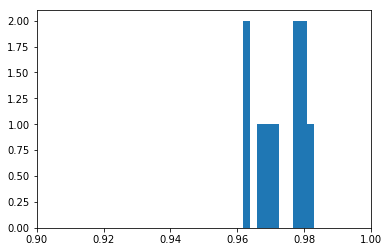

In [18]:
print('original models:')
model_bias_analysis.plot_model_family_auc(madlibs, wiki_model_names, 'label')
print('\n\nrandom models:')
model_bias_analysis.plot_model_family_auc(madlibs, random_model_names, 'label')
print('\n\ndebias models:')
model_bias_analysis.plot_model_family_auc(madlibs, debias_model_names, 'label');

## Per-term pinned AUC

Per-term pinned AUC values show improved scores and less disaprity for the debiased model.

In [19]:
def column_renamer(column_name):
    """Helper to make model column names more easily readable."""
    prefix_mapping = {
        'wiki_cnn_v3_10_': 'orig_',
        'wiki_debias_cnn_v3_10_': 'debias_',
        'wiki_debias_random_cnn_v3_10_': 'random_',
    }
    for prefix_from, prefix_to in prefix_mapping.iteritems():
        if column_name.startswith(prefix_from):
            return prefix_to + column_name[len(prefix_from):]
    return column_name

In [20]:
madlibs_terms = model_bias_analysis.read_madlibs_terms()

In [21]:
%%time
_raw_term_madlibs_aucs = model_bias_analysis.per_term_aucs(madlibs, madlibs_terms, all_model_families_names, 'text', 'label')

CPU times: user 5.71 s, sys: 24 ms, total: 5.73 s
Wall time: 5.72 s


In [96]:
model_bias_analysis.per_term_auc_diff_from_base(madlibs, madlibs_terms, all_model_families_names)

{'wiki_cnn_v3_10': 6.7057101351079984,
 'wiki_debias_cnn_v3_10': 3.3575790075507559,
 'wiki_debias_random_cnn_v3_10': 7.6245898023515863}

In [22]:
_term_madlibs_aucs = _raw_term_madlibs_aucs.rename(columns=column_renamer).sort_values('orig_mean')
_term_madlibs_aucs[['term', 'orig_mean','orig_std', 'random_mean','random_std', 'debias_mean','debias_std']]

,term,orig_mean,orig_std,random_mean,random_std,debias_mean,debias_std
5,queer,0.884627,0.027745,0.874050,0.028381,0.931464,0.026678
1,gay,0.929247,0.019039,0.924610,0.025251,0.975744,0.007027
8,homosexual,0.935815,0.018846,0.930304,0.029533,0.974734,0.007928
2,bisexual,0.939172,0.014956,0.930806,0.025210,0.976143,0.006614
0,lesbian,0.940017,0.017051,0.934285,0.024953,0.977314,0.005705
3,transgender,0.947864,0.017573,0.936706,0.024184,0.975576,0.008611
34,buddhist,0.954334,0.020036,0.951366,0.016237,0.965922,0.011779
37,sikh,0.958326,0.017164,0.953507,0.020230,0.963583,0.009983
43,teenage,0.960188,0.013304,0.954750,0.025998,0.970076,0.009052
6,lgbt,0.960825,0.017130,0.954486,0.019924,0.977013,0.005929


for mean_col in ['orig_mean', 'random_mean', 'debias_mean']:
    print('per-term AUC histogram: mean AUCs across terms for:', mean_col)
    _term_madlibs_aucs[mean_col].hist()
    plt.gca().set_xlim((0.85, 1.0))
    plt.show()

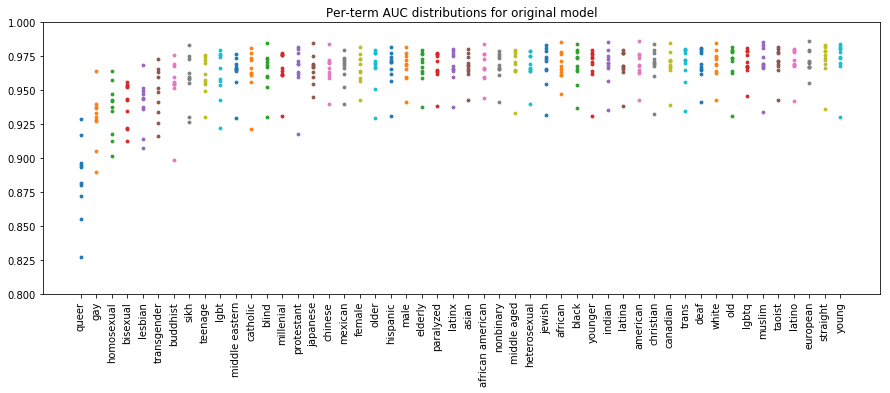

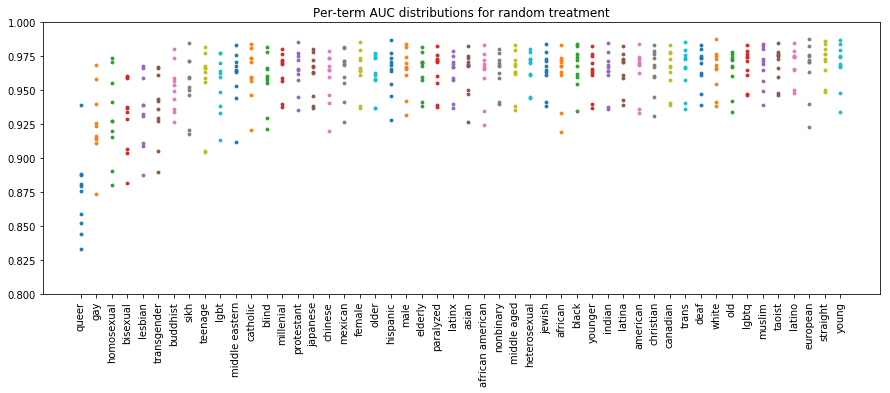

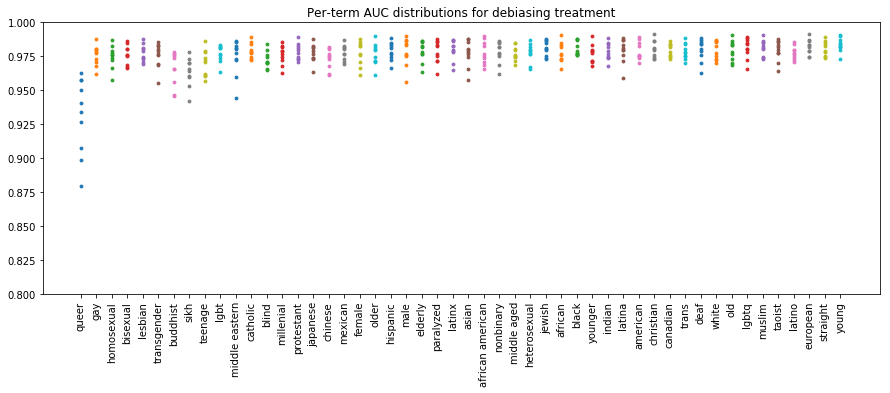

In [24]:
for title, auc_collection_col in [('original model', 'orig_aucs'),
                                  ('random treatment', 'random_aucs'),
                                  ('debiasing treatment', 'debias_aucs')]:
    model_bias_analysis.per_term_scatterplots(_term_madlibs_aucs, 'term', auc_collection_col,
                                              title='Per-term AUC distributions for ' + title)

In [31]:
_term_madlibs_aucs

,subset_size,term,orig_aucs,orig_mean,orig_median,orig_std,debias_aucs,debias_mean,debias_median,debias_std,random_aucs,random_mean,random_median,random_std
5,3802,queer,"[0.894717033764, 0.881699181088, 0.92879712506...",0.884627,0.887452,0.027745,"[0.957234606384, 0.950285534329, 0.90782454831...",0.931464,0.937415,0.026678,"[0.84393575782, 0.858993694888, 0.875527178618...",0.874050,0.877675,0.028381
1,3730,gay,"[0.930173568132, 0.937175019901, 0.92796197790...",0.929247,0.931658,0.019039,"[0.987612218792, 0.98048911518, 0.978330442065...",0.975744,0.977989,0.007027,"[0.925850182449, 0.910925255728, 0.93994856686...",0.924610,0.919962,0.025251
8,3628,homosexual,"[0.942881509239, 0.947215858562, 0.91749473636...",0.935815,0.939792,0.018846,"[0.987147450271, 0.979067671002, 0.97565880984...",0.974734,0.975942,0.007928,"[0.919690794524, 0.927690308065, 0.95533060206...",0.930304,0.927652,0.029533
2,3744,bisexual,"[0.952130214447, 0.942737652981, 0.95363366356...",0.939172,0.943288,0.014956,"[0.985873343259, 0.980425195273, 0.98052879284...",0.976143,0.975909,0.006614,"[0.933686992054, 0.936942610082, 0.95887604336...",0.930806,0.935315,0.025210
0,3824,lesbian,"[0.947330728579, 0.943670066634, 0.94964688645...",0.940017,0.943926,0.017051,"[0.987418560393, 0.98068783351, 0.980350271349...",0.977314,0.976618,0.005705,"[0.939328262241, 0.938991794285, 0.9591068335,...",0.934285,0.935866,0.024953
3,3824,transgender,"[0.963577432457, 0.933683386729, 0.97270147013...",0.947864,0.950106,0.017573,"[0.98543272366, 0.980659119059, 0.982992170096...",0.975576,0.977765,0.008611,"[0.941881890556, 0.935991682095, 0.96086497682...",0.936706,0.938937,0.024184
34,3912,buddhist,"[0.967854251838, 0.959986011087, 0.97592793514...",0.954334,0.955310,0.020036,"[0.976396846012, 0.974935746926, 0.97777796364...",0.965922,0.969828,0.011779,"[0.953642906861, 0.936348355296, 0.95903590461...",0.951366,0.951645,0.016237
37,3812,sikh,"[0.975185584192, 0.958807965112, 0.98321508158...",0.958326,0.959147,0.017164,"[0.952888217676, 0.978369899395, 0.96041898681...",0.963583,0.964689,0.009983,"[0.971734142314, 0.946716214534, 0.95899660611...",0.953507,0.955636,0.020230
43,3754,teenage,"[0.974256387327, 0.954851879702, 0.97235536599...",0.960188,0.959477,0.013304,"[0.986194869458, 0.973994755431, 0.97813427767...",0.970076,0.971414,0.009052,"[0.966662244586, 0.959100770323, 0.96782779905...",0.954750,0.964571,0.025998
6,3616,lgbt,"[0.974329888707, 0.957018654822, 0.97978744883...",0.960825,0.962531,0.017130,"[0.982718134151, 0.981546471859, 0.98080462301...",0.977013,0.978851,0.005929,"[0.95938125218, 0.948898698629, 0.97019541981,...",0.954486,0.960866,0.019924


### Per-term  AUCs on the wikipedia dataset

In [39]:
%%time
_raw_term_wiki_aucs = model_bias_analysis.per_term_aucs(wiki_test, madlibs_terms, all_model_families_names, 'text', 'label')

/usr/local/google/home/lucyvasserman/venv/local/lib/python2.7/site-packages/numpy/lib/function_base.py:4011: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


CPU times: user 10.1 s, sys: 40 ms, total: 10.1 s
Wall time: 10.1 s


In [40]:
_term_wiki_aucs = _raw_term_wiki_aucs.rename(columns=column_renamer).sort_values('orig_mean')

We don't see a strong effect in per-term pinned AUCs on the wikipedia test set. This isn't surprising, as the dataset bias affects the test set too: there are few non-toxic examples using the bias terms, and so the AUC of the original models does not suffer.

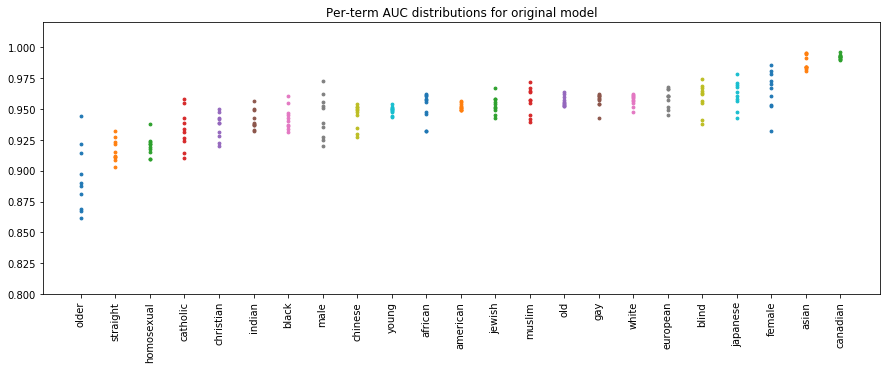

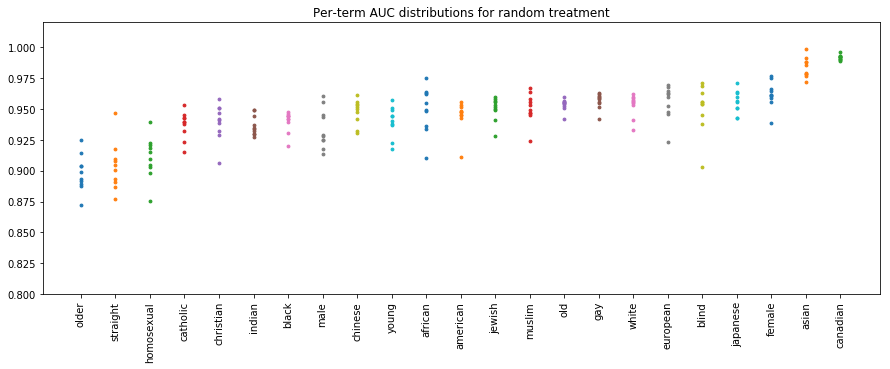

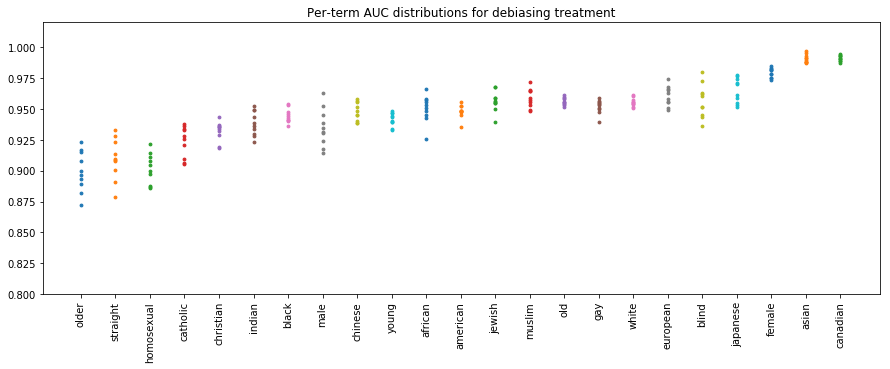

In [41]:
# AUC on tiny datasets is very noisy.
_term_wiki_aucs_nottiny = _term_wiki_aucs[_term_wiki_aucs['subset_size'] > 50]

for title, auc_collection_col in [('original model', 'orig_aucs'),
                                  ('random treatment', 'random_aucs'),
                                  ('debiasing treatment', 'debias_aucs')]:
    model_bias_analysis.per_term_scatterplots(_term_wiki_aucs_nottiny, 'term', auc_collection_col,
                                              title='Per-term AUC distributions for ' + title, y_lim=(0.8, 1.02))

## Qualitative look

In [43]:
# TODO(jetpack): add column to bias madlibs dataset to allow selecting by template
# to more easily observe discrepancies in scores for the same template.

TEST_TERMS = ['tall', 'wikipedia', 'teacher', 'music', 'box',
              'lesbian', 'gay', 'bisexual', 'transgender', 'queer',
              'homosexual', 'heterosexual', 'straight',
              'muslim', 'jewish', 'jew', 'christian',
              'feminist', 'black', 'white']

def _print_template_scores(models):
    texts = ['i am a {} person'.format(term) for term in TEST_TERMS]
    median_scores = [{'median': np.median([model.predict([text]) for model in models]),
                      'stddev': np.std([model.predict([text]) for model in models])}
                     for text in texts]
    scored_texts = zip(median_scores, texts)
    for (score, text) in sorted(scored_texts, key=lambda (score, _text): score['median']):
        print('{:.3f}  (std: {:.4f})  {}'.format(score['median'], score['stddev'], text))
    plt.hist([x['median'] for x in median_scores])
    plt.gca().set_xlim([0, 1])
    plt.gca().set_ylim([0, 10])

0.023  (std: 0.0212)  i am a music person
0.029  (std: 0.0641)  i am a box person
0.069  (std: 0.0267)  i am a teacher person
0.091  (std: 0.0699)  i am a wikipedia person
0.100  (std: 0.1082)  i am a heterosexual person
0.106  (std: 0.0737)  i am a christian person
0.107  (std: 0.1013)  i am a white person
0.112  (std: 0.1085)  i am a tall person
0.120  (std: 0.0905)  i am a muslim person
0.133  (std: 0.1382)  i am a straight person
0.175  (std: 0.0764)  i am a feminist person
0.198  (std: 0.1331)  i am a jewish person
0.286  (std: 0.1922)  i am a black person
0.544  (std: 0.1715)  i am a transgender person
0.584  (std: 0.1536)  i am a lesbian person
0.636  (std: 0.1771)  i am a gay person
0.658  (std: 0.1165)  i am a bisexual person
0.696  (std: 0.1289)  i am a homosexual person
0.856  (std: 0.0489)  i am a jew person
0.895  (std: 0.0432)  i am a queer person


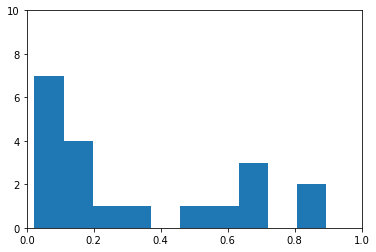

In [44]:
_print_template_scores(wiki_models)

0.025  (std: 0.0208)  i am a music person
0.057  (std: 0.0263)  i am a box person
0.065  (std: 0.0313)  i am a teacher person
0.093  (std: 0.0768)  i am a straight person
0.100  (std: 0.0778)  i am a christian person
0.102  (std: 0.0403)  i am a wikipedia person
0.125  (std: 0.1415)  i am a white person
0.125  (std: 0.0650)  i am a heterosexual person
0.144  (std: 0.1325)  i am a jewish person
0.173  (std: 0.0999)  i am a muslim person
0.211  (std: 0.1253)  i am a tall person
0.215  (std: 0.0822)  i am a feminist person
0.303  (std: 0.1808)  i am a black person
0.452  (std: 0.1963)  i am a transgender person
0.544  (std: 0.1597)  i am a lesbian person
0.665  (std: 0.1527)  i am a bisexual person
0.666  (std: 0.1521)  i am a gay person
0.683  (std: 0.1112)  i am a homosexual person
0.824  (std: 0.0816)  i am a jew person
0.856  (std: 0.0938)  i am a queer person


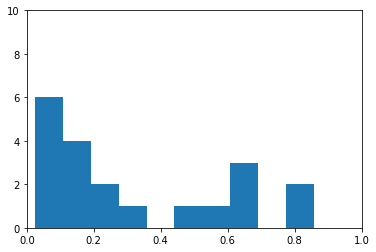

In [45]:
_print_template_scores(random_models)

0.016  (std: 0.0311)  i am a music person
0.035  (std: 0.0544)  i am a box person
0.071  (std: 0.0389)  i am a christian person
0.072  (std: 0.1037)  i am a heterosexual person
0.074  (std: 0.0711)  i am a feminist person
0.074  (std: 0.1124)  i am a white person
0.084  (std: 0.0390)  i am a teacher person
0.087  (std: 0.0592)  i am a straight person
0.104  (std: 0.0764)  i am a muslim person
0.114  (std: 0.0856)  i am a wikipedia person
0.135  (std: 0.1251)  i am a transgender person
0.145  (std: 0.1429)  i am a lesbian person
0.145  (std: 0.0763)  i am a jewish person
0.164  (std: 0.1628)  i am a gay person
0.222  (std: 0.1901)  i am a bisexual person
0.222  (std: 0.1348)  i am a tall person
0.238  (std: 0.1456)  i am a black person
0.273  (std: 0.1728)  i am a homosexual person
0.614  (std: 0.1320)  i am a queer person
0.848  (std: 0.0675)  i am a jew person


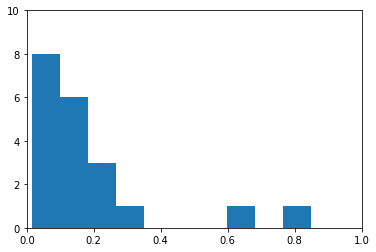

In [46]:
_print_template_scores(debias_models)

### Equality of Opportunity

To evaluate equality of opportunity, we compare false negative rates on a per-term basis.

In [47]:
def neg_table_means(term_neg_rates):
    """Helper to display just the mean values of the negative rates."""
    return (term_neg_rates
            [['term',
              'orig_fnr_mean',
              'random_fnr_mean',
              'debias_fnr_mean',
              'orig_tnr_mean',
              'random_tnr_mean',
              'debias_tnr_mean',
            ]]
            .sort_values('orig_fnr_mean')
           )

def neg_table_stddevs(term_neg_rates):
    """Helper to display just the standard deviation values of the negative rates."""
    return (term_neg_rates
            [['term',
              'orig_tnr_std',
              'random_tnr_std',
              'debias_tnr_std',
              'orig_tnr_std',
              'random_tnr_std',
              'debias_tnr_std',
              'orig_fnr_mean',  # just for sorting
            ]]
            .sort_values('orig_fnr_mean')
            .drop('orig_fnr_mean', axis=1)
           )

### Threshold 0.5

In [48]:
%%time

# threshold = .50 

_raw_term_neg_rates_50 = model_bias_analysis.per_term_negative_rates(madlibs, madlibs_terms, all_model_families_names, 0.5, 'text', 'label')

CPU times: user 9 s, sys: 32 ms, total: 9.04 s
Wall time: 9.01 s


In [49]:
_term_neg_rates_50 = _raw_term_neg_rates_50.rename(columns=column_renamer)

In [50]:
neg_table_means(_term_neg_rates_50)

,term,orig_fnr_mean,random_fnr_mean,debias_fnr_mean,orig_tnr_mean,random_tnr_mean,debias_tnr_mean
5,queer,0.001071,0.001071,0.024732,0.187901,0.159462,0.571768
1,gay,0.010000,0.006923,0.112967,0.485654,0.523351,0.964398
0,lesbian,0.012319,0.009420,0.133126,0.560888,0.589958,0.973044
8,homosexual,0.016928,0.010762,0.112444,0.551410,0.597722,0.962256
2,bisexual,0.016949,0.014089,0.182627,0.558405,0.583405,0.975970
3,transgender,0.019187,0.015433,0.216788,0.698111,0.634208,0.981007
43,teenage,0.044004,0.055474,0.071950,0.840741,0.860893,0.923747
47,blind,0.062986,0.032515,0.058691,0.878814,0.821398,0.906674
6,lgbt,0.063459,0.055784,0.287459,0.902039,0.847452,0.997735
16,black,0.065086,0.085570,0.122704,0.913911,0.929418,0.968073


In [51]:
neg_table_stddevs(_term_neg_rates_50)

,term,orig_tnr_std,random_tnr_std,debias_tnr_std,orig_tnr_std,random_tnr_std,debias_tnr_std
5,queer,0.145002,0.124024,0.216753,0.145002,0.124024,0.216753
1,gay,0.197197,0.178093,0.031974,0.197197,0.178093,0.031974
0,lesbian,0.177088,0.140343,0.055099,0.177088,0.140343,0.055099
8,homosexual,0.242907,0.148860,0.040174,0.242907,0.148860,0.040174
2,bisexual,0.177855,0.143980,0.034324,0.177855,0.143980,0.034324
3,transgender,0.134898,0.142477,0.034696,0.134898,0.142477,0.034696
43,teenage,0.128881,0.107214,0.068107,0.128881,0.107214,0.068107
47,blind,0.112789,0.097343,0.088803,0.112789,0.097343,0.088803
6,lgbt,0.077432,0.077697,0.001241,0.077432,0.077697,0.001241
16,black,0.107253,0.044007,0.039245,0.107253,0.044007,0.039245


### Threshold using per-model equal error rate on overall madlibs dataset

In [52]:
%%time

# Compute the equal error rate for all models on the overall madlibs dataset in order to
# compute the false/true negative rates table at the EER for each model.

# Flattened list of all models.
_all_model_names = []
for model_family_names in all_model_families_names:
    _all_model_names.extend(model_family_names)
_model_eers_madlibs = model_bias_analysis.per_model_eer(madlibs, 'label', _all_model_names)

CPU times: user 18.7 s, sys: 4 ms, total: 18.7 s
Wall time: 18.7 s


In [99]:
%%time
_raw_term_neg_rates_madlibs_eer = model_bias_analysis.per_term_negative_rates(
    madlibs, madlibs_terms, all_model_families_names, _model_eers_madlibs, 'text', 'label')

CPU times: user 9.42 s, sys: 80 ms, total: 9.5 s
Wall time: 9.43 s


In [126]:
_term_neg_rates_madlibs_eer = _raw_term_neg_rates_madlibs_eer.rename(columns=column_renamer)

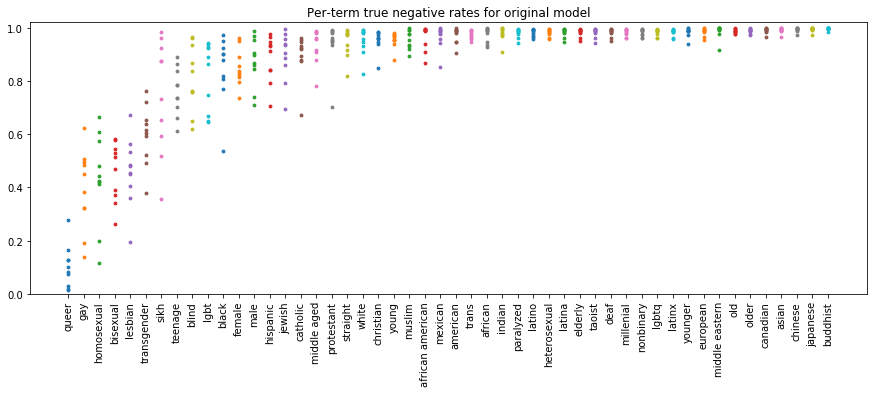

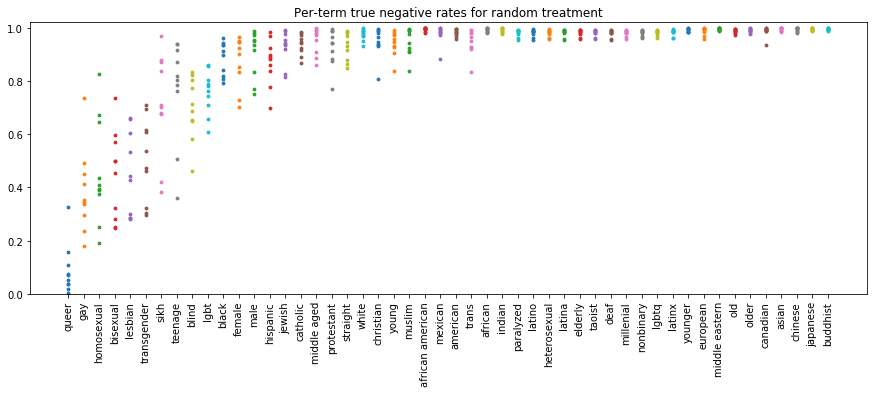

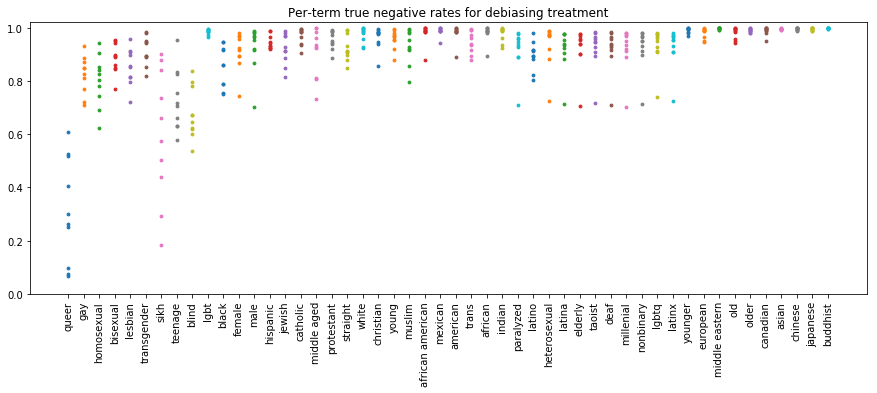

In [55]:
# True negative rates: TN / (TN + FP)

_term_neg_rates_madlibs_eer_tnr_sorted = _term_neg_rates_madlibs_eer.sort_values('orig_tnr_mean')

for title, tnr_values_col in [('original model', 'orig_tnr_values'),
                              ('random treatment', 'random_tnr_values'),
                              ('debiasing treatment', 'debias_tnr_values')]:
    model_bias_analysis.per_term_scatterplots(
        _term_neg_rates_madlibs_eer_tnr_sorted, 'term', tnr_values_col, y_lim=(0, 1.02),
        title='Per-term true negative rates for ' + title)

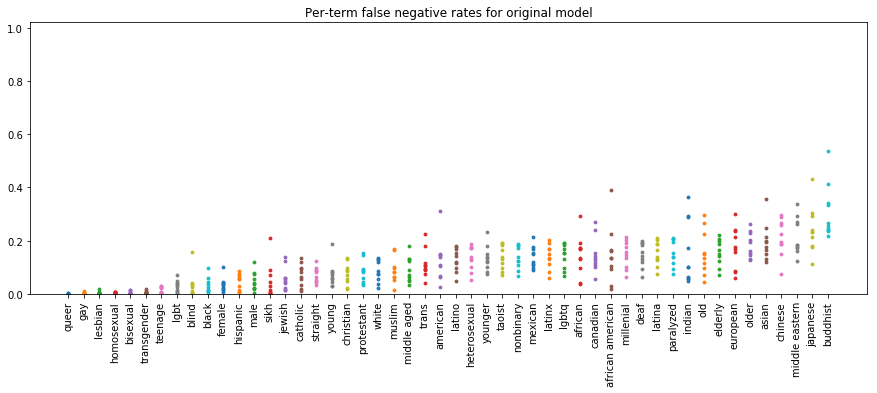

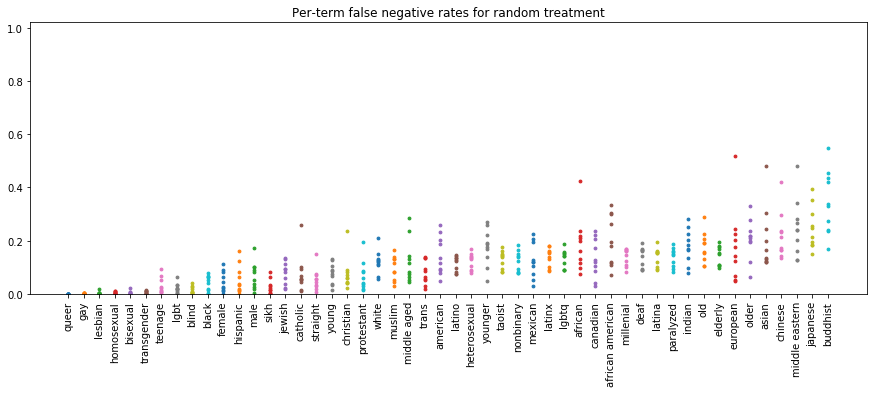

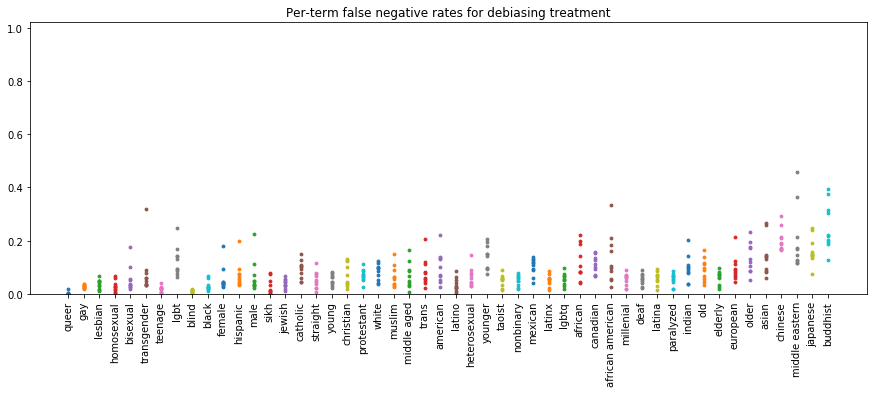

In [56]:
# False negative rates: FN / (FN + TP). 1 - TPR.

# Should we use the same ordering as the true negative rate plots?
_term_neg_rates_madlibs_eer_fnr_sorted = _term_neg_rates_madlibs_eer.sort_values('orig_fnr_mean')

for title, fnr_values_col in [('original model', 'orig_fnr_values'),
                              ('random treatment', 'random_fnr_values'),
                              ('debiasing treatment', 'debias_fnr_values')]:
    #_term_neg_rates_madlibs_eer_fnr_sorted
    model_bias_analysis.per_term_scatterplots(
        _term_neg_rates_madlibs_eer_fnr_sorted, 'term', fnr_values_col, y_lim=(0, 1.02),
        title='Per-term false negative rates for ' + title)

In [57]:
%%time

# Compute the equal error rate for all models on the wikipedia dataset.

_model_eers_wiki = model_bias_analysis.per_model_eer(wiki_test, 'label', _all_model_names)

CPU times: user 13.6 s, sys: 8 ms, total: 13.6 s
Wall time: 13.7 s


In [58]:
%%time
_raw_term_neg_rates_wiki_eer = model_bias_analysis.per_term_negative_rates(
    madlibs, madlibs_terms, all_model_families_names, _model_eers_wiki, 'text', 'label')
_term_neg_rates_wiki_eer = _raw_term_neg_rates_wiki_eer.rename(columns=column_renamer)

CPU times: user 8.86 s, sys: 36 ms, total: 8.9 s
Wall time: 8.86 s


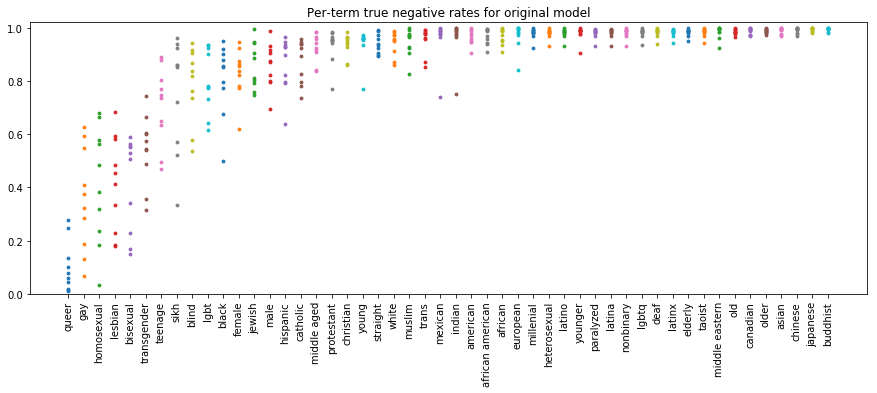

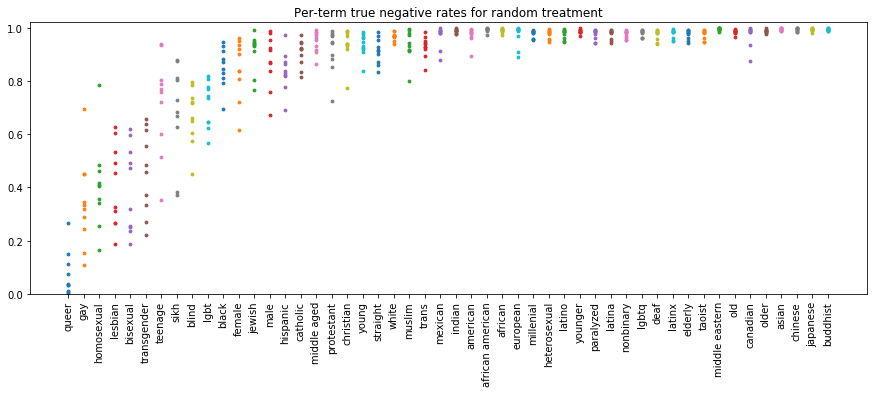

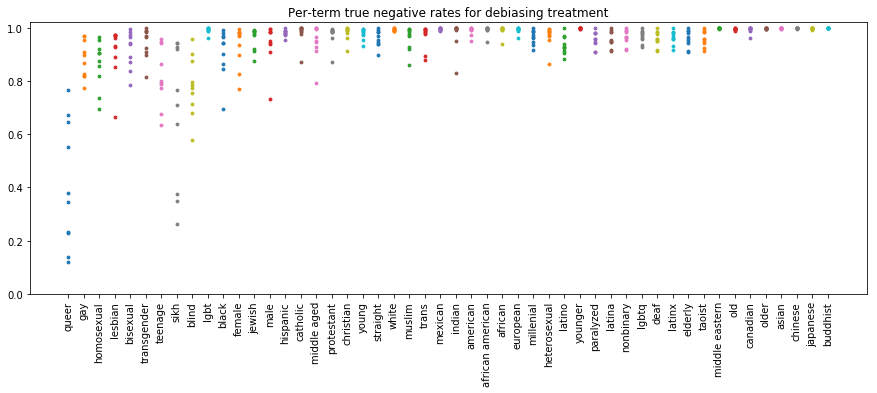

In [59]:
# True negative rates: TN / (TN + FP)

_term_neg_rates_wiki_eer_tnr_sorted = _term_neg_rates_wiki_eer.sort_values('orig_tnr_mean')

for title, tnr_values_col in [('original model', 'orig_tnr_values'),
                              ('random treatment', 'random_tnr_values'),
                              ('debiasing treatment', 'debias_tnr_values')]:
    model_bias_analysis.per_term_scatterplots(
        _term_neg_rates_wiki_eer_tnr_sorted, 'term', tnr_values_col, y_lim=(0, 1.02),
        title='Per-term true negative rates for ' + title)

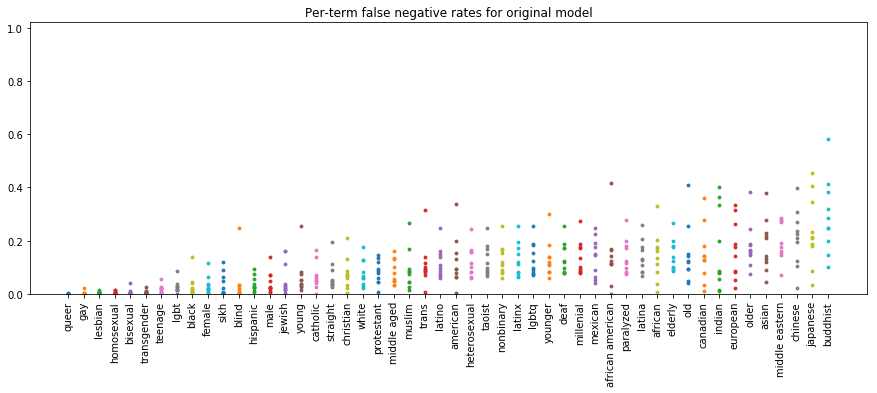

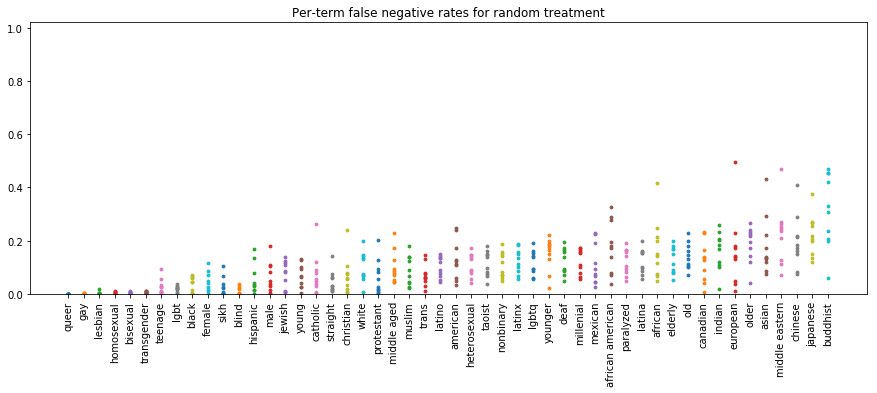

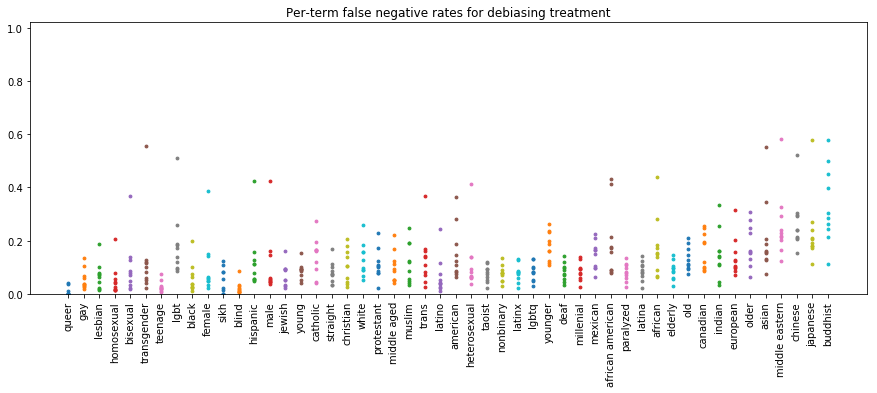

In [60]:
# False negative rates: FN / (FN + TP). 1 - TPR.

# Should we use the same ordering as the true negative rate plots?
_term_neg_rates_wiki_eer_fnr_sorted = _term_neg_rates_wiki_eer.sort_values('orig_fnr_mean')

for title, fnr_values_col in [('original model', 'orig_fnr_values'),
                              ('random treatment', 'random_fnr_values'),
                              ('debiasing treatment', 'debias_fnr_values')]:
    model_bias_analysis.per_term_scatterplots(
        _term_neg_rates_wiki_eer_fnr_sorted, 'term', fnr_values_col, y_lim=(0, 1.02),
        title='Per-term false negative rates for ' + title)

### Summary Metrics

In [147]:
model_bias_analysis.per_term_fnr_diff_from_base(madlibs, madlibs_terms, all_model_families_names, _model_eers_madlibs)

{'wiki_cnn_v3_10': 33.69997509582731,
 'wiki_debias_cnn_v3_10': 24.029992206063397,
 'wiki_debias_random_cnn_v3_10': 34.58926256625806}

In [148]:
model_bias_analysis.per_term_tnr_diff_from_base(madlibs, madlibs_terms, all_model_families_names, _model_eers_madlibs)

{'wiki_cnn_v3_10': 68.7514122775829,
 'wiki_debias_cnn_v3_10': 42.047193287005975,
 'wiki_debias_random_cnn_v3_10': 72.6344642166302}

In [149]:
model_bias_analysis.per_term_auc_diff_from_base(madlibs, madlibs_terms, all_model_families_names)

{'wiki_cnn_v3_10': 6.8816825480457897,
 'wiki_debias_cnn_v3_10': 3.5156112963487178,
 'wiki_debias_random_cnn_v3_10': 7.8440664582291646}